In [1]:
#Voronoi方法：先根据PINN的区域生成指定数目的Voronoi种子；然后在该区域内生成配位点；然后使用最近邻搜索算法，找到每个配位点的最近种子点，从而确定每个配位点的区域；

In [2]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



from scipy.spatial import Voronoi, voronoi_plot_2d 
#scipy.spatial提供了空间数据结构和算法的功能。主要用于处理和分析多维空间中的数据。包括了一系列用于计算多维空间中点集的函数和类，例如距离计算、空间关系、空间结构和形状分析等
#Voronoi是一个用于生成Voronoi图的类。Voronoi图是一种将平面分割成多个区域的方法，每个区域由一组特定的点定义，这些点距离区域内的任何位置都比距离区域外的其他点更近。
#voronoi_plot_2d是一个用于绘制二维Voronoi图的函数。它接受一个Voronoi对象作为输入，并生成该Voronoi图的可视化表示


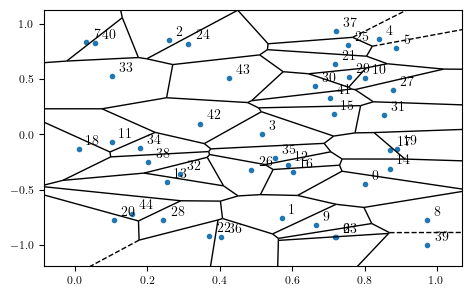

In [3]:
#1.根据PINN的区域生成指定数目的Voronoi种子

# 生成一个Voronoi-Poisson划分，这意味着它生成一个Poisson点过程，然后使用它生成一个相应的Voronoi细分。Voronoi细分也称为Dirichlet细分或Voronoi图。

# 在矩形上创建一个（均匀）Poisson点过程（PPP，Poisson point process），然后使用SciPy函数Voronoi找到Voronoi镶嵌，该函数基于Qhull项目[2]。
# PPP的所有点和Voronoi单元都是任意编号的。

# [1] http://scipy.github.io/devdocs/generated/scipy.spatial.Voronoi.html
# [2] http://www.qhull.org/

plt.close('all')  #关闭所有之前的图形界面，确保从一个干净的状态开始绘图

#定义模拟窗口的边界
xMin = 0
xMax = 1
yMin = -1
yMax = 1

xDelta = xMax - xMin #区域宽度
yDelta = yMax - yMin #区域高度
areaTotal = xDelta * yDelta #区域面积

# PPP的强度，即单位面积内点的平均密度
lambda0 = 20

# 模拟泊松点过程（PPP）
numbPoints = np.random.poisson(lambda0 * areaTotal)  # 泊松点（种子）数量，点数量为随机数生成，随机数是泊松分布，期望值和方差为区域面积乘以PPP强度（密度）
xx = xDelta * np.random.uniform(0, 1, numbPoints) + xMin  # 泊松点的x坐标，具体为一个随机数×区域宽度加上区域最小x坐标，即在模拟区域内按均匀分布随机采样numbPoints个点
yy = yDelta * np.random.uniform(0, 1, numbPoints) + yMin  # 泊松点的y坐标，具体为一个随机数×区域高度加上区域最小y坐标，即在模拟区域内按均匀分布随机采样numbPoints个点

seed=np.stack((xx,yy), axis=1) #将x和y坐标合并成一个数组，即种子的坐标，形状为(n,2)，n为点的数量


#使用内置函数执行Voronoi图生成

voronoiData=Voronoi(seed) #使用Voronoi函数进行Voronoi划分，得到Voronoi图的数据
#Voronoi函数的输入是一个点集(也就是每个单位的种子，二维的话为(n,2)形状)，输出是一个Voronoi对象，包含了Voronoi图的所有信息，包括顶点、边和单元等
vertexAll=voronoiData.vertices #从数据中提取所有Voronoi顶点
cellAll=voronoiData.regions #从数据中提取所有Voronoi单元，一些单元可能为空

#绘制Voronoi图和PPP
#使用内嵌函数绘制Voronoi图，其中show_points和show_vertices参数控制是否显示生成点（即seed/Voronoi的输入点/数据）和顶点（Voronoi各个单元的交点）
voronoi_plot_2d(voronoiData, show_points=True,show_vertices=False)


#给每个点添加编号
for ii in range(numbPoints):
    plt.text(xx[ii]+xDelta/50, yy[ii]+yDelta/50, ii) #在图标的某个位置上添加文本，文本内容为点的编号，位置为点的坐标加上区域宽度和高度的1/50（为了做微调）
   

In [4]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [5]:
#2.生成配位点，X_f_train第一列表示x，第二列表示t
X_f_train = caiyang(1000, "LHS") 

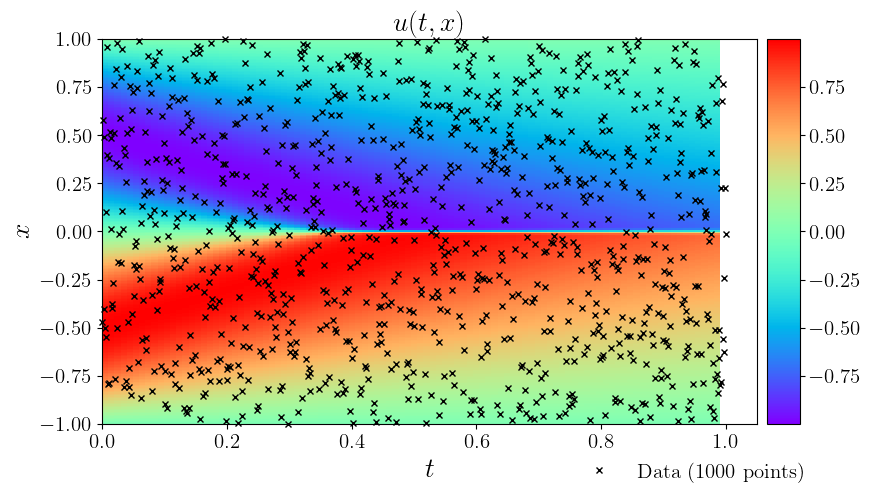

In [6]:
#绘制PINN热图和配位点的分布情况

data = scipy.io.loadmat('../../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [7]:
#互换配位点的第一列和第二列，为了和seed的坐标匹配，互换后X_f_train变为X_f_swapped，第一列表示t，第二列表示x
print(seed)
print(X_f_train)
# 互换第一列和第二列
# 先复制原始数据
X_f_swapped = np.copy(X_f_train)

# 在复制的数组上互换第一列和第二列
X_f_swapped[:, [0, 1]] = X_f_swapped[:, [1, 0]]

print(X_f_swapped)

[[ 0.80089959 -0.45196501]
 [ 0.57200073 -0.75728166]
 [ 0.25972769  0.85108678]
 [ 0.51723008  0.00415198]
 [ 0.83890394  0.86237314]
 [ 0.88817156  0.78071786]
 [ 0.71989407 -0.92318985]
 [ 0.0320776   0.83553869]
 [ 0.97179926 -0.7732836 ]
 [ 0.66554446 -0.81866173]
 [ 0.80268086  0.50576133]
 [ 0.1033939  -0.06850814]
 [ 0.58842829 -0.27259409]
 [ 0.25480054 -0.42618457]
 [ 0.87081519 -0.30807871]
 [ 0.71494576  0.18321298]
 [ 0.60300647 -0.34107805]
 [ 0.87154699 -0.13719703]
 [ 0.01127346 -0.1308177 ]
 [ 0.8885835  -0.1311095 ]
 [ 0.10744369 -0.77081955]
 [ 0.71767608  0.63738242]
 [ 0.37183445 -0.92167979]
 [ 0.72040629 -0.92567199]
 [ 0.31354771  0.82027869]
 [ 0.7537633   0.80458659]
 [ 0.48775433 -0.32326494]
 [ 0.87933663  0.4046386 ]
 [ 0.24454212 -0.76944347]
 [ 0.75740622  0.51825212]
 [ 0.66343395  0.43343234]
 [ 0.8534275   0.17460919]
 [ 0.29084478 -0.35764362]
 [ 0.10355094  0.53081948]
 [ 0.1806025  -0.12292298]
 [ 0.55200648 -0.21513731]
 [ 0.40456641 -0.92329239]
 

In [8]:
#3.使用最近邻搜索算法，找到每个配位点的最近种子点

from scipy.spatial import cKDTree #用于创建k维空间中的k-d树（k-dimensional tree）。k-d树是一种数据结构，用于组织和查询在k维度空间中的点


# 创建 cKDTree 实例，seed形状是(n,k=2)，n是种子点的数量，k为空间维度，该函数将种子点组织到一个k-d树中，以便快速查询最近邻点。可以使用tree上的方法执行各种空间查询
tree = cKDTree(seed)

# 对每个点进行最邻近搜索
distances, indices = tree.query(X_f_swapped) #用于执行查询操作，对于X_f_swapped中的每个点，查找并返回tree上最近的种子点的距离和索引

# indices 数组中的每个元素都是对应点最近的种子点的索引，可以使用这个索引作为标签

# 打印每个点的最近种子点索引
for i, index in enumerate(indices):
    print(f"点 {X_f_swapped[i]} 最近的种子点是 {seed[index]}，索引（标签）为 {index}")

点 [0.6895 0.813 ] 最近的种子点是 [0.7537633  0.80458659]，索引（标签）为 25
点 [0.6485 0.327 ] 最近的种子点是 [0.70491991 0.32461548]，索引（标签）为 41
点 [ 0.2175 -0.993 ] 最近的种子点是 [ 0.37183445 -0.92167979]，索引（标签）为 22
点 [ 0.6405 -0.385 ] 最近的种子点是 [ 0.60300647 -0.34107805]，索引（标签）为 16
点 [ 0.9695 -0.429 ] 最近的种子点是 [ 0.87081519 -0.30807871]，索引（标签）为 14
点 [0.7575 0.041 ] 最近的种子点是 [0.71494576 0.18321298]，索引（标签）为 15
点 [ 0.1835 -0.675 ] 最近的种子点是 [ 0.15834067 -0.71428274]，索引（标签）为 44
点 [0.5805 0.985 ] 最近的种子点是 [0.72174697 0.93318372]，索引（标签）为 37
点 [0.7995 0.579 ] 最近的种子点是 [0.80268086 0.50576133]，索引（标签）为 10
点 [0.9565 0.587 ] 最近的种子点是 [0.80268086 0.50576133]，索引（标签）为 10
点 [ 0.8035 -0.545 ] 最近的种子点是 [ 0.80089959 -0.45196501]，索引（标签）为 0
点 [ 0.6505 -0.815 ] 最近的种子点是 [ 0.66554446 -0.81866173]，索引（标签）为 9
点 [ 0.9535 -0.635 ] 最近的种子点是 [ 0.97179926 -0.7732836 ]，索引（标签）为 8
点 [0.5065 0.585 ] 最近的种子点是 [0.42561832 0.51252289]，索引（标签）为 43
点 [ 0.2875 -0.803 ] 最近的种子点是 [ 0.24454212 -0.76944347]，索引（标签）为 28
点 [ 0.0595 -0.179 ] 最近的种子点是 [ 0.01127346 -0.1308177 ]，索引

In [9]:
#获得具体某一个数据点最近的种子

dis, index = tree.query(X_f_swapped[5]) #返回目标点最近的种子在seed数组中的距离和索引（即该点所在的单元索引）

nearest_seed = seed[index] #返回目标点最近的种子点坐标

print(index) #打印索引，即该点所在的单元索引
print(nearest_seed) #打印最近的种子点坐标
print(X_f_swapped[5]) #打印该点坐标

15
[0.71494576 0.18321298]
[0.7575 0.041 ]


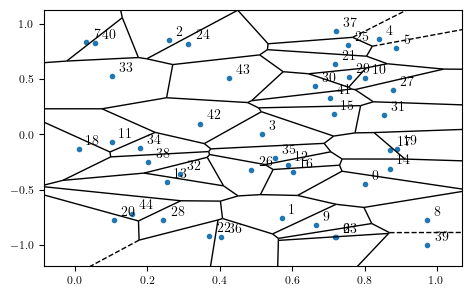

In [10]:
voronoiData=Voronoi(seed) #使用Voronoi函数进行Voronoi划分，得到Voronoi图的数据
#Voronoi函数的输入是一个点集(二维的话为(n,2)形状)，输出是一个Voronoi对象，包含了Voronoi图的所有信息，包括顶点、边和单元等
vertexAll=voronoiData.vertices #从数据中提取所有Voronoi顶点
cellAll=voronoiData.regions #从数据中提取所有Voronoi单元，一些单元可能为空

#绘制Voronoi图和PPP
#使用内嵌函数绘制Voronoi图，其中show_points和show_vertices参数控制是否显示生成点（即seed/Voronoi的输入点/数据）和顶点（Voronoi各个单元的交点）
voronoi_plot_2d(voronoiData, show_points=True,show_vertices=False)

# plt.scatter(xx, yy, edgecolor='b', facecolor='r') #绘制泊松点的散点图，设置三点的边缘颜色为蓝色，填充颜色为红


#给每个点添加编号
for ii in range(numbPoints):
    plt.text(xx[ii]+xDelta/50, yy[ii]+yDelta/50, ii) #在图标的某个位置上添加文本，文本内容为点的编号，位置为点的坐标加上区域宽度和高度的1/50（为了做微调）

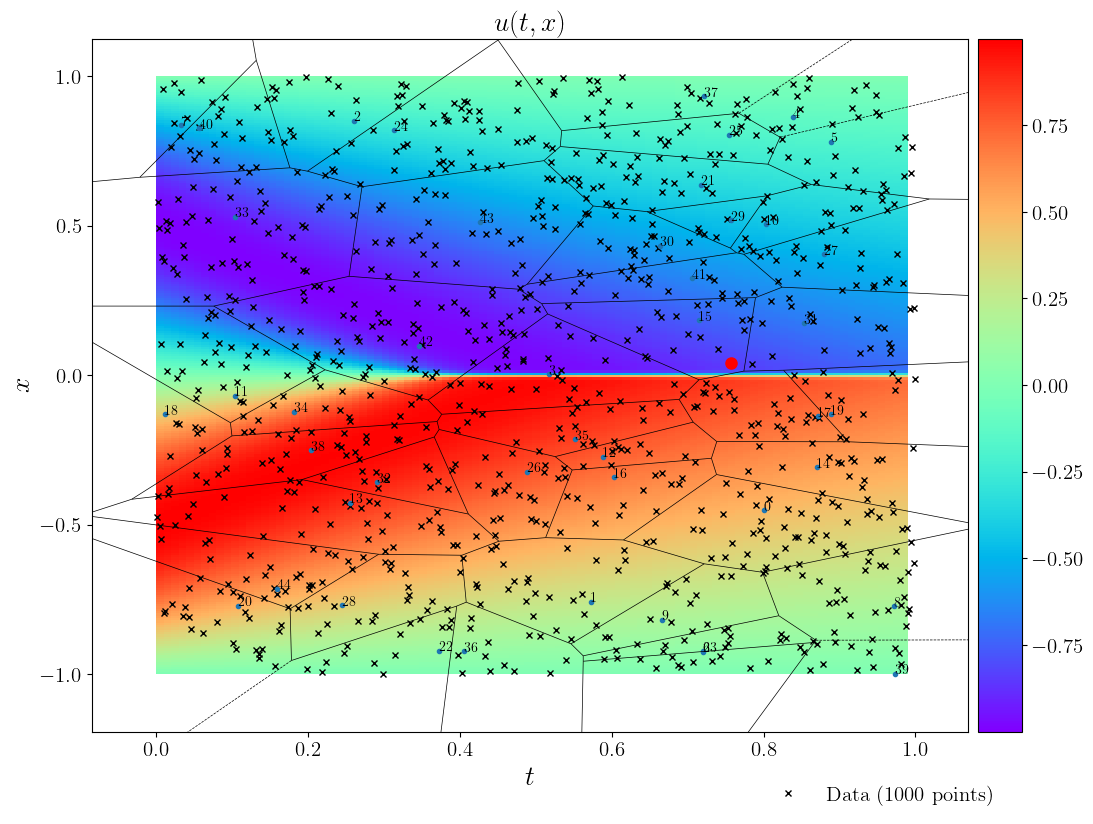

In [11]:
data = scipy.io.loadmat('../../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(12, 9)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  


voronoi_plot_2d(voronoiData, ax=ax, show_points=True, show_vertices=False, line_colors='k', line_width=0.5)

#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#给每个点添加编号
for ii in range(numbPoints):
    ax.text(xx[ii], yy[ii], ii) #在图标的某个位置上添加文本，文本内容为点的编号，位置为点的坐标加上区域宽度和高度的1/50（为了做微调）
    
#在图上绘制第五个点的情况
ax.plot(
    X_f_train[5,1], 
    X_f_train[5,0], 
    'ro',  
    markersize = 8,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  

#显示图片
plt.show() #显示所有打开的图形的函数